# Q4:  WGAN, DCGAN <br> by: Ariel Kantorovich

In [68]:
!nvidia-smi

Mon Mar  4 16:11:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.33.01              Driver Version: 546.29       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P3              35W /  50W |   4906MiB /  8192MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import Relvant Libryras

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

# Load cuda if exsist

In [70]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device recognize = {device}")

Device recognize = cuda


# Load and Transform Fashion Mnist Dataset

In [71]:
down_flag = False # Optional
# Define Transform normalization
transform = transforms.Compose([transforms.ToTensor()])
# Load Train Data
train_data = datasets.FashionMNIST('F_MNIST_data', download=down_flag, train=True, transform=transform)
# Load Test Data
test_data = datasets.FashionMNIST('F_MNIST_data', download=down_flag, train=False, transform=transform)

train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: F_MNIST_data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: F_MNIST_data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

# Iterating and Visualizing the Dataset

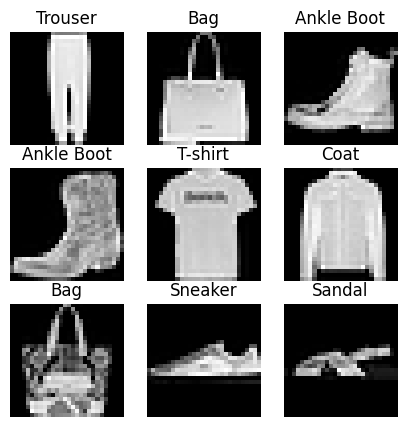

In [72]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (5,5))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

Split to train and valid in addition prepare dataloader for training

In [73]:
# Hyper-parameters
batch_size = 128
valid_size = 0.2
# Data Loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# DCGAN Archticture

Hyparparmeters

In [74]:
# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [75]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
        # input is Z, going into a convolution
        nn.ConvTranspose2d(in_channels=nz, out_channels=ngf*8, kernel_size=4, stride=1, padding=0),
        nn.BatchNorm2d(ngf*8),
        nn.ReLU(),
        # state size. ``(ngf*8) x 4 x 4``
        nn.ConvTranspose2d(in_channels=ngf*8, out_channels=ngf*4, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(),
        # state size. ``(ngf*4) x 8 x 8``
        nn.ConvTranspose2d(in_channels=ngf*4, out_channels=ngf*2, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(),
         # state size. ``(ngf*2) x 16 x 16``
        nn.ConvTranspose2d(in_channels=ngf*2, out_channels=ngf, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(ngf),
        nn.ReLU(),
         # state size. ``(ngf) x 32 x 32``
        nn.Conv2d(in_channels=ngf, out_channels=nc, kernel_size=5, stride=1, padding=0),
        nn.Sigmoid()
        # state size. ``(nc) x 28 x 28``
        )
    
    def forward(self, x):
        return self.model(x)

Weight Initalization Optional

In [76]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [77]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is ``(nc) x 28 x 28``
            nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 26 x 26``
            nn.Conv2d(in_channels=ndf, out_channels=ndf * 2, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2),
            # state size. ``(ndf*2) x 12 x 12``
            nn.Conv2d(in_channels=ndf * 2, out_channels=ndf * 4, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2),
            # state size. ``(ndf*4) x 5 x 5``
            nn.Conv2d(in_channels=ndf * 4, out_channels=nc, kernel_size=3, stride=2, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2),
            # state size. ``(nc) x 1 x 1``
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

In [78]:
# Define Models
netG = Generator().to(device)
netD = Discriminator().to(device)
# Apply weights Initializetion
netG.apply(weights_init)
netD.apply(weights_init)

print(netG)
print(netD)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1))
    (13): Sigmoid()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope

# Define Optimizer and creterion to DCGAN

In [79]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

DCGAN Train Loop

In [80]:
def Train_DCGAN(netD, netG, 
                optimizerD, optimizerG,
                criterion, num_epochs,
                train_loader):
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    for epoch in range(num_epochs):
        netD.train()
        netG.train()
        for i, (data, _) in enumerate(train_loader, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data.to(device)
            b_size = real_cpu.shape[0]
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(train_loader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(make_grid(fake, padding=2, normalize=True))

            iters += 1
    return G_losses, D_losses, img_list

In [81]:
Gen_loss, Disc_loss, imgas_list = Train_DCGAN(netD, netG, 
                                            optimizerD, optimizerG,
                                            criterion, num_epochs,
                                            train_loader)

[0/5][0/469]	Loss_D: 1.3391	Loss_G: 0.9459	D(x): 0.4554	D(G(z)): 0.4215 / 0.3890
[0/5][50/469]	Loss_D: 1.1251	Loss_G: 1.1257	D(x): 0.6467	D(G(z)): 0.4561 / 0.3279
[0/5][100/469]	Loss_D: 1.2184	Loss_G: 1.0498	D(x): 0.4797	D(G(z)): 0.3701 / 0.3522
[0/5][150/469]	Loss_D: 0.6565	Loss_G: 0.9615	D(x): 0.8808	D(G(z)): 0.3983 / 0.3842
[0/5][200/469]	Loss_D: 0.7199	Loss_G: 1.0111	D(x): 0.8573	D(G(z)): 0.4144 / 0.3683
[0/5][250/469]	Loss_D: 1.2811	Loss_G: 1.1908	D(x): 0.7397	D(G(z)): 0.5665 / 0.3070
[0/5][300/469]	Loss_D: 0.7972	Loss_G: 1.0058	D(x): 0.7677	D(G(z)): 0.3854 / 0.3675
[0/5][350/469]	Loss_D: 0.7384	Loss_G: 0.9304	D(x): 0.8197	D(G(z)): 0.4025 / 0.3976
[0/5][400/469]	Loss_D: 0.6604	Loss_G: 1.0127	D(x): 0.8912	D(G(z)): 0.4074 / 0.3657
[0/5][450/469]	Loss_D: 0.6726	Loss_G: 0.9680	D(x): 0.8965	D(G(z)): 0.4210 / 0.3825
[1/5][0/469]	Loss_D: 0.6228	Loss_G: 1.0290	D(x): 0.8871	D(G(z)): 0.3818 / 0.3614
[1/5][50/469]	Loss_D: 0.9055	Loss_G: 1.1268	D(x): 0.8518	D(G(z)): 0.4823 / 0.3277
[1/5][100/

# Plot and Display Results

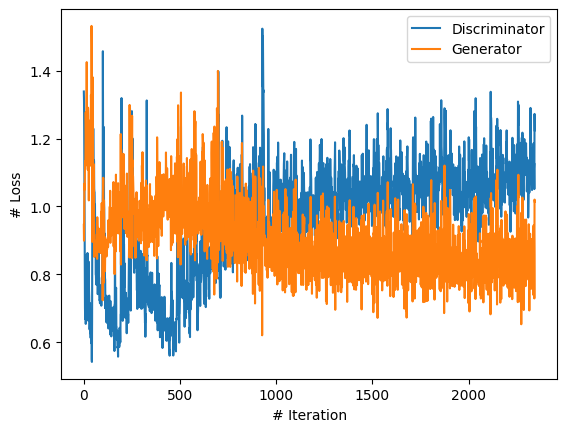

(<matplotlib.legend.Legend at 0x7f7afc1fd2e0>,
 Text(0.5, 24.0, '# Iteration'),
 Text(24.000000000000007, 0.5, '# Loss'),
 None)

In [82]:
iteration = np.arange(len(Disc_loss))
plt.plot(iteration, Disc_loss, label="Discriminator"),
plt.plot(iteration, Gen_loss, label="Generator"),
plt.legend(), plt.xlabel("# Iteration"), plt.ylabel("# Loss"), plt.show()

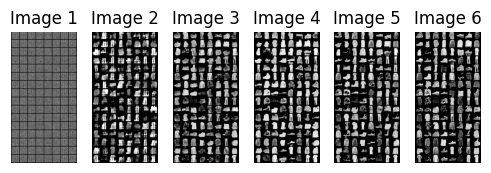

In [83]:
# Assuming 'imgas_list' is your list of image tensors
fig, axes = plt.subplots(1, len(imgas_list), figsize=(5, 5*len(imgas_list)))

for i, img in enumerate(imgas_list):
    # Convert the tensor to a NumPy array
    img_np = img.cpu().numpy()

    # Transpose the array if necessary to match the channel dimension
    if img_np.shape[0] == 3:
        img_np = img_np.transpose(1, 2, 0)

    # Display the image
    axes[i].imshow(img_np)
    axes[i].set_title("Image {}".format(i+1))
    axes[i].axis('off')  # Turn off axis

plt.tight_layout()  # Adjust layout
plt.show()

# Save results

In [84]:
# Assuming netG and netD are your trained generator and discriminator models
torch.save(netG.state_dict(), 'generator_model(DCGAN).pth')
torch.save(netD.state_dict(), 'discriminator_model(DCGAN).pth')

# WGAN Archticture

In [85]:
class Generator_WGAN(nn.Module):

    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator_WGAN, self).__init__()    
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.get_generator_block(z_dim, 
                                     hidden_dim * 4,
                                     kernel_size=3, 
                                     stride=2),      
            self.get_generator_block(hidden_dim * 4, 
                                     hidden_dim * 2,
                                     kernel_size=4,
                                     stride = 1),
            self.get_generator_block(hidden_dim * 2,
                                     hidden_dim ,
                                     kernel_size=3,
                                     stride = 2,
                                    ),
            self.get_generator_final_block(hidden_dim,
                                           im_chan,
                                           kernel_size=4,
                                           stride=2)
        )
        
        
    def get_generator_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace=True),
        )
    
    
    def get_generator_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.Sigmoid()
            )
    
    
    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

In [86]:
class Critic(nn.Module):

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            self.get_critic_block(im_chan,
                                         hidden_dim * 4,
                                         kernel_size=4,
                                         stride=2),
            
            self.get_critic_block(hidden_dim * 4,
                                         hidden_dim * 8,
                                         kernel_size=4,
                                         stride=2,),
            
            self.get_critic_final_block(hidden_dim * 8,
                                               1,
                                               kernel_size=4,
                                               stride=2,),

        )

        
    def get_critic_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
        )
    
    
    def get_critic_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
            )
    
    def forward(self, image):
        return self.disc(image)

Some help functions

In [87]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)

In [88]:
def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)

    gradient_norm = gradient.norm(2, dim=1)
    
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

In [89]:
def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss

In [90]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

In [91]:
def get_gradient(crit, real, fake, epsilon):

    mixed_images = real * epsilon + fake * (1 - epsilon)

    mixed_scores = crit(mixed_images)
    
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
        
    )[0]
    return gradient

In [92]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), show_fig=False, epoch=0):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())  
    plt.show()

# WGAN Train loop

In [93]:
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999
z_dim = 100
batch_size = 128
fixed_noise = get_noise(batch_size, z_dim, device=device)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

        
gen = Generator_WGAN(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

crit  = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

gen = gen.apply(weights_init)
crit = crit.apply(weights_init)  

Epoch: 0/20 Steps:469/469	Loss_C : -20.711457	Loss_G : -1.171245	Loss_C_Mean : -8.176683	Loss_G_Mean : -1.348281	


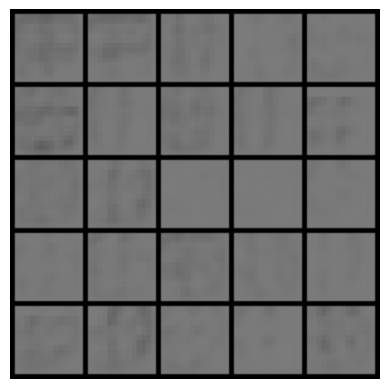

Epoch: 1/20 Steps:469/469	Loss_C : -63.614794	Loss_G : -2.386954	Loss_C_Mean : -36.871098	Loss_G_Mean : -2.256711	


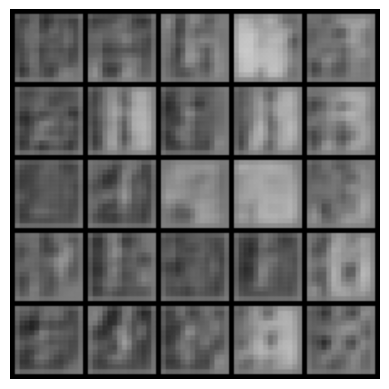

Epoch: 2/20 Steps:469/469	Loss_C : -2.370631	Loss_G : -9.301932	Loss_C_Mean : -39.594263	Loss_G_Mean : -6.554950	


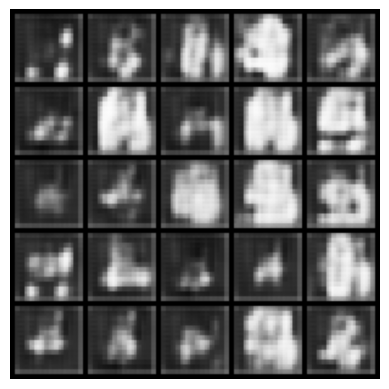

Epoch: 3/20 Steps:469/469	Loss_C : -107.079031	Loss_G : -11.648567	Loss_C_Mean : -37.197393	Loss_G_Mean : -13.177314	


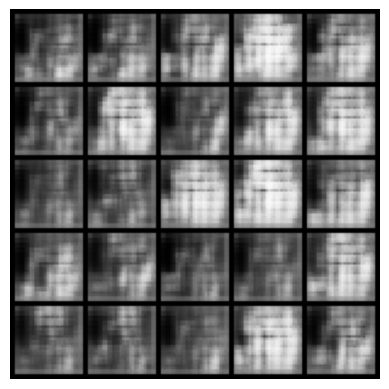

Epoch: 4/20 Steps:469/469	Loss_C : 4.677012	Loss_G : -10.296190	Loss_C_Mean : -115.819788	Loss_G_Mean : -7.904183	


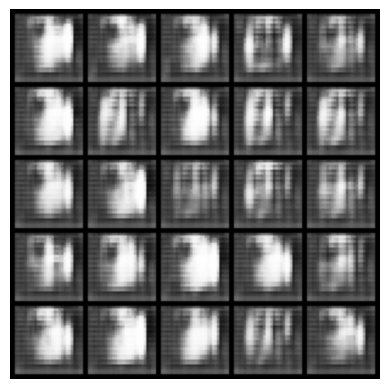

Epoch: 5/20 Steps:469/469	Loss_C : -2.305250	Loss_G : -10.805021	Loss_C_Mean : -2.103705	Loss_G_Mean : -9.878549	


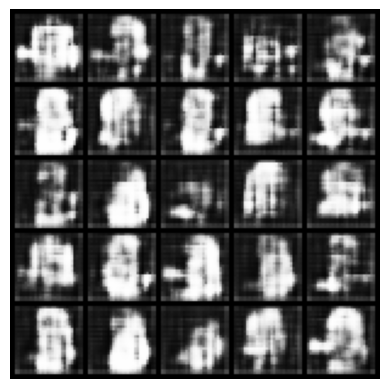

Epoch: 6/20 Steps:469/469	Loss_C : -2.800599	Loss_G : -11.019646	Loss_C_Mean : -1.762294	Loss_G_Mean : -10.944991	


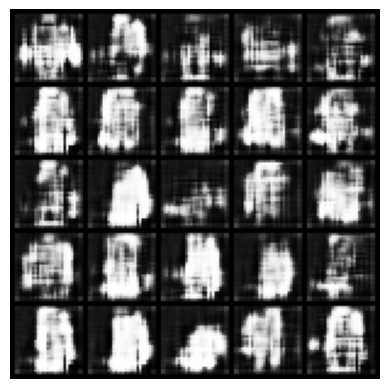

Epoch: 7/20 Steps:469/469	Loss_C : -1.423360	Loss_G : -11.682711	Loss_C_Mean : -1.770185	Loss_G_Mean : -11.547706	


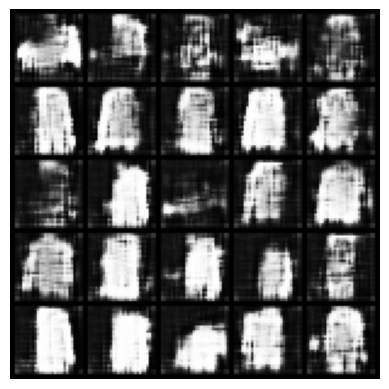

Epoch: 8/20 Steps:469/469	Loss_C : -1.296423	Loss_G : -13.167793	Loss_C_Mean : -0.976589	Loss_G_Mean : -13.194674	


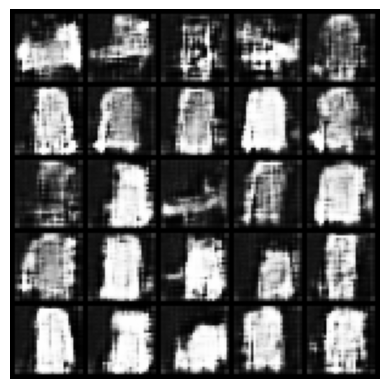

Epoch: 9/20 Steps:469/469	Loss_C : -1.665407	Loss_G : -12.224066	Loss_C_Mean : -1.357623	Loss_G_Mean : -11.906225	


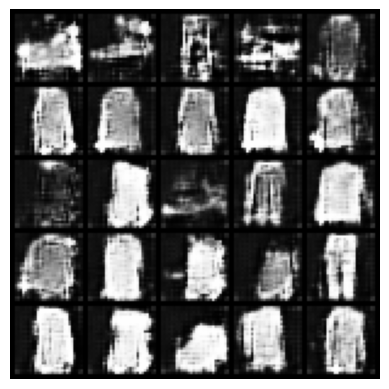

Epoch: 10/20 Steps:469/469	Loss_C : -1.574546	Loss_G : -12.318605	Loss_C_Mean : -1.364794	Loss_G_Mean : -12.306363	


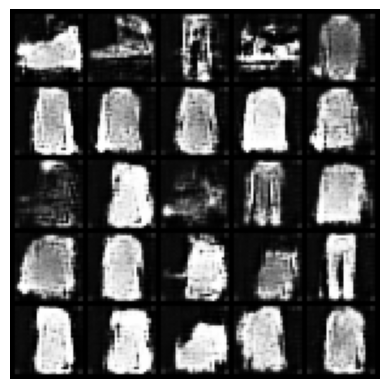

Epoch: 11/20 Steps:469/469	Loss_C : -1.173157	Loss_G : -12.760710	Loss_C_Mean : -1.138632	Loss_G_Mean : -12.765024	


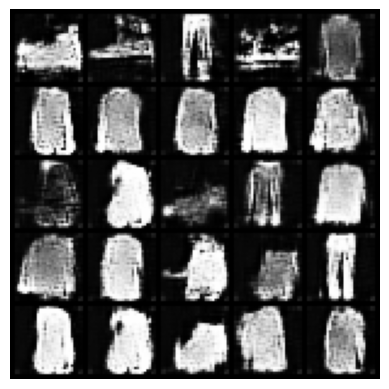

Epoch: 12/20 Steps:469/469	Loss_C : -1.015036	Loss_G : -13.389494	Loss_C_Mean : -1.080279	Loss_G_Mean : -13.003592	


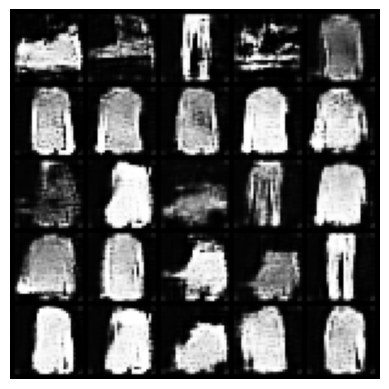

Epoch: 13/20 Steps:469/469	Loss_C : -0.997185	Loss_G : -13.451927	Loss_C_Mean : -0.932258	Loss_G_Mean : -13.374420	


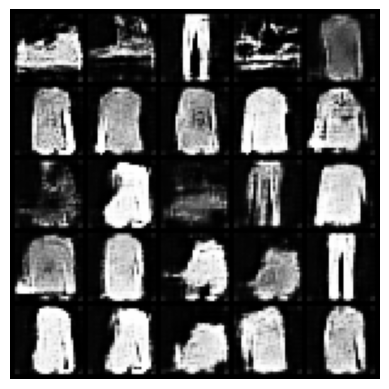

Epoch: 14/20 Steps:469/469	Loss_C : -0.673158	Loss_G : -12.987001	Loss_C_Mean : -0.798239	Loss_G_Mean : -13.408173	


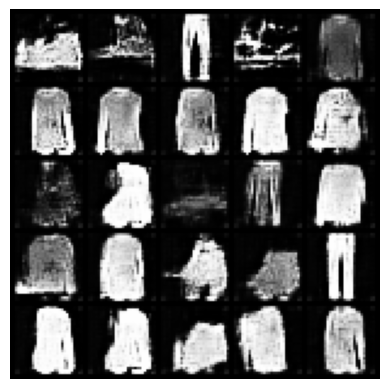

Epoch: 15/20 Steps:469/469	Loss_C : -0.853171	Loss_G : -12.358812	Loss_C_Mean : -0.799910	Loss_G_Mean : -13.557014	


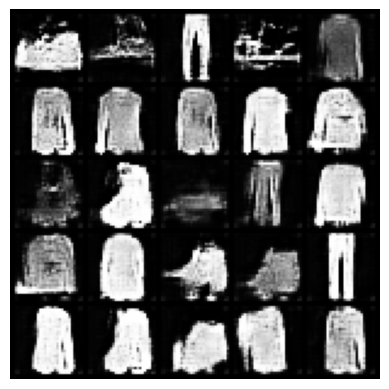

Epoch: 16/20 Steps:469/469	Loss_C : -0.680072	Loss_G : -12.756544	Loss_C_Mean : -0.784011	Loss_G_Mean : -13.166236	


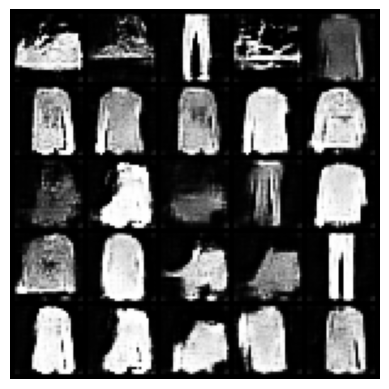

Epoch: 17/20 Steps:469/469	Loss_C : -0.883738	Loss_G : -13.029358	Loss_C_Mean : -0.690170	Loss_G_Mean : -13.107320	


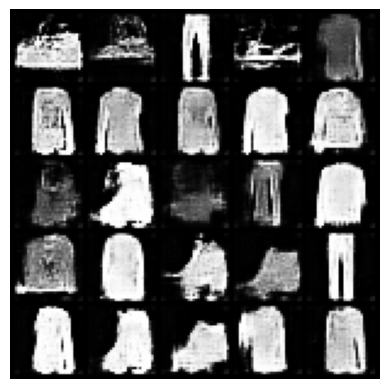

Epoch: 18/20 Steps:469/469	Loss_C : -0.652918	Loss_G : -12.899447	Loss_C_Mean : -0.730624	Loss_G_Mean : -12.744836	


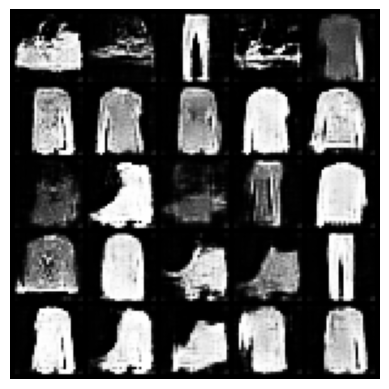

Epoch: 19/20 Steps:469/469	Loss_C : -1.118877	Loss_G : -11.742713	Loss_C_Mean : -0.684658	Loss_G_Mean : -12.320475	


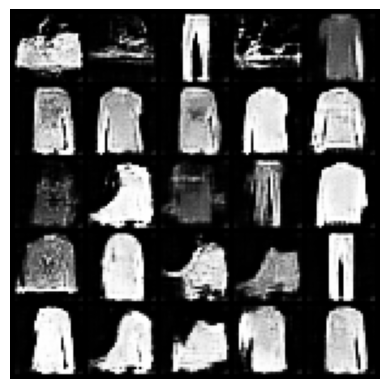

In [94]:
n_epochs = 20
cur_step = 0
total_steps = 0
cur_step = 0

generator_losses = []
critic_losses = []

C_mean_losses = []
G_mean_losses = []

c_lambda = 10
crit_repeats = 5
display_step = 50

for epoch in range(n_epochs):
    cur_step = 0
    for real, _ in train_loader:
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]
        
        cur_step += 1
        total_steps += 1
        
        print_val = f"Epoch: {epoch}/{n_epochs} Steps:{cur_step}/{len(train_loader)}\t"
        print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
        print_val += f"Loss_G : {gen_loss:.6f}\t"  
        print(print_val, end='\r',flush = True)

    gen_mean = sum(generator_losses[-cur_step:]) / cur_step
    crit_mean = sum(critic_losses[-cur_step:]) / cur_step
    
    C_mean_losses.append(crit_mean)
    G_mean_losses.append(gen_mean)
    
    print_val = f"Epoch: {epoch}/{n_epochs} Steps:{cur_step}/{len(train_loader)}\t"
    print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
    print_val += f"Loss_G : {gen_loss:.6f}\t"
    print_val += f"Loss_C_Mean : {crit_mean:.6f}\t"
    print_val += f"Loss_G_Mean : {gen_mean:.6f}\t"
    print(print_val)
    
    fake_noise = fixed_noise
    fake = gen(fake_noise)
    
    show_tensor_images(fake, show_fig=True,epoch=epoch)
    
    cur_step = 0

# Save WGAN results

In [95]:
# Assuming netG and netD are your trained generator and discriminator models
torch.save(gen.state_dict(), 'generator_model(WGAN).pth')
torch.save(crit.state_dict(), 'discriminator_model(WGAN).pth')

# Plot results

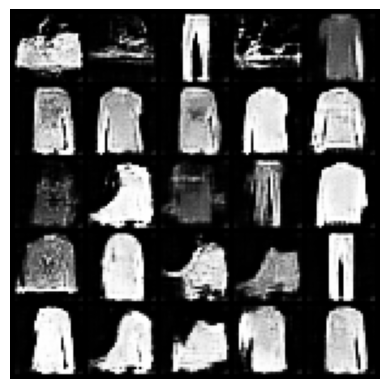

In [96]:
show_tensor_images(fake, show_fig=True,epoch=epoch)

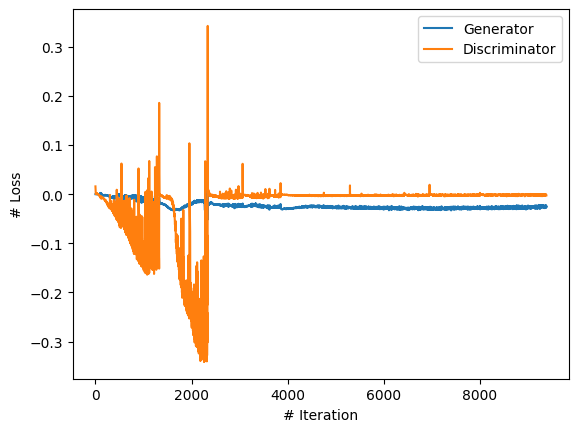

(<matplotlib.legend.Legend at 0x7f7afc0b1070>,
 Text(0.5, 24.0, '# Iteration'),
 Text(24.000000000000007, 0.5, '# Loss'),
 None)

In [101]:
iteration = np.arange(len(generator_losses))
plt.plot(iteration, np.array(generator_losses)/469, label="Generator"),
plt.plot(iteration, np.array(critic_losses)/469, label="Discriminator"),
plt.legend(), plt.xlabel("# Iteration"), plt.ylabel("# Loss"), plt.show()

# Compare Results between WGAN and DCGAN

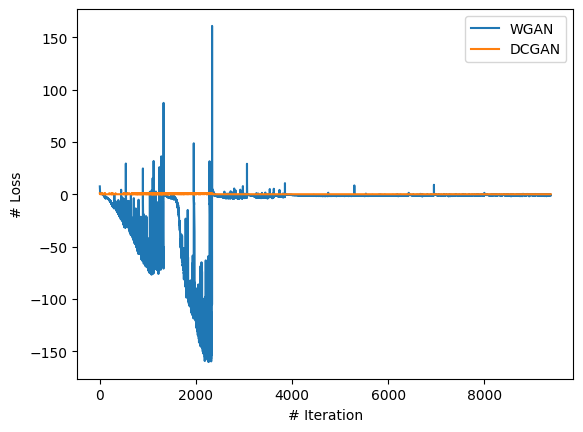

(<matplotlib.legend.Legend at 0x7f7ad5b63f10>,
 Text(0.5, 24.0, '# Iteration'),
 Text(24.0, 0.5, '# Loss'),
 None)

In [114]:
iteration = np.arange(len(generator_losses))
DCGAN_Dics = np.zeros_like(iteration)
DCGAN_Dics[0:len(Disc_loss)] = Disc_loss
DCGAN_Dics[len(DCGAN_Dics):] = Disc_loss[-1]
plt.plot(iteration, np.array(critic_losses), label="WGAN"),
plt.plot(iteration, DCGAN_Dics, label="DCGAN"),
plt.legend(), plt.xlabel("# Iteration"), plt.ylabel("# Loss"), plt.show()

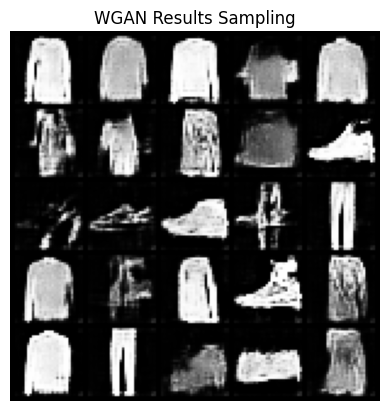

In [120]:
fake_noise = get_noise(cur_batch_size, z_dim, device=device)
size = (1, 28, 28)
num_images=25
with torch.no_grad():
    fake = gen(fake_noise)
image_unflat = fake.detach().cpu().view(-1, *size)
image_grid = make_grid(image_unflat[:num_images], nrow=5)
plt.axis('off'), plt.title("WGAN Results Sampling")
plt.imshow(image_grid.permute(1, 2, 0).squeeze())  
plt.show()

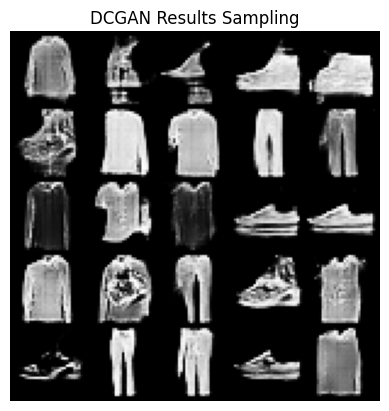

In [125]:
fixed_noise = torch.randn(25, nz, 1, 1, device=device)
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
image_unflat = fake.view(-1, *size)
image_grid = make_grid(image_unflat[:num_images], nrow=5)
plt.axis('off'), plt.title("DCGAN Results Sampling")
plt.imshow(image_grid.permute(1, 2, 0).squeeze())  
plt.show()

# Test Code

Load Generatice model

In [131]:
# Load the pre-trained weights
Genrator_DCGAN = "generator_model(DCGAN).pth"
netG.load_state_dict(torch.load(Genrator_DCGAN))

Genrator_WGAN = "generator_model(WGAN).pth"
gen.load_state_dict(torch.load(Genrator_WGAN))

# Set the model to evaluation mode
netG.eval()
gen.eval()

Generator_WGAN(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
      (1): Sigmoid()
    )
  )
)

Test WGAN

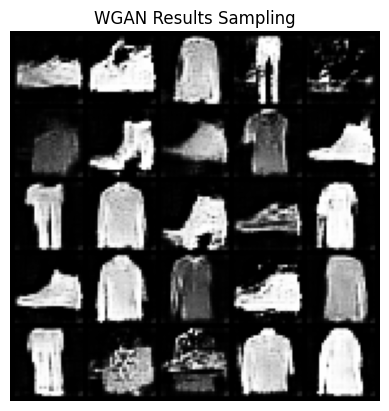

In [132]:
fake_noise = get_noise(cur_batch_size, z_dim, device=device)
size = (1, 28, 28)
num_images=25
with torch.no_grad():
    fake = gen(fake_noise)
image_unflat = fake.detach().cpu().view(-1, *size)
image_grid = make_grid(image_unflat[:num_images], nrow=5)
plt.axis('off'), plt.title("WGAN Results Sampling")
plt.imshow(image_grid.permute(1, 2, 0).squeeze())  
plt.show()

Test DCGAN

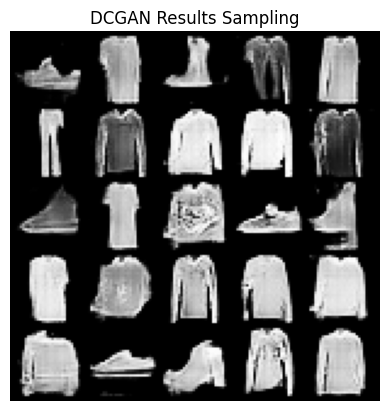

In [133]:
fixed_noise = torch.randn(25, nz, 1, 1, device=device)
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
image_unflat = fake.view(-1, *size)
image_grid = make_grid(image_unflat[:num_images], nrow=5)
plt.axis('off'), plt.title("DCGAN Results Sampling")
plt.imshow(image_grid.permute(1, 2, 0).squeeze())  
plt.show()